# goals
- feature engineering
    - missing twitter data
    - normal distributions
    - independent variables
    - OHE categorical variables
    - conditional group variables
    - impute missing station numbers
    - normalize
    - look at PCA
- regress on Fall 17
    - Linear Model
    - KNN Regressor
    - Decision Tree Regressor
    - Random Forest Regressor
    - SVM Regressor
    - Gradient Boost Regressor
- classify Fall 17 groups (low, mid, high) ????

In [1]:
# tools
import numpy as np # linear algebra
np.random.seed(42)
import pandas as pd # data processing
import seaborn as sns # plotting
import matplotlib.pyplot as plt # plotting
from scipy import stats # t-test
import time # runtime
from sklearn import metrics # roc, auc score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# models
from sklearn.linear_model import LinearRegression # Linear(fit_intercept=True, normalize=False, n_jobs=1)
from sklearn.neighbors import KNeighborsRegressor # KNN(n_neighbors=5, weights='uniform', n_jobs=1)
from sklearn.tree import DecisionTreeRegressor # DTR(max_depth=None, min_samples_split=2, max_features=None, max_leaf_nodes=None)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor # RFR(n_estimators=10, max_depth=None, min_samples_split=2, max_features='auto', max_leaf_nodes=None, n_jobs=1), GBR(learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=3, max_features=None, max_leaf_nodes=None)
from sklearn.svm import SVR # SVR(kernel='rbf')

In [17]:
df = pd.read_csv('clean_data.csv').drop('Unnamed: 0', axis = 1)
df.drop(['Station','Market Name','Rank'], axis = 1, inplace = True)
# dropna
df = df[~df['Fall 17'].isnull()]
print ("Rows\t{}\nColumns {}".format(df.shape[0],df.shape[1]))
display(df.head(3))

Rows	2110
Columns 17


,Format,Population,Spr 17,Spr 16,Black,State,Fall 16,Hispanic,Owner,Fall 17,Followers Count,Friends Count,Listed Count,Created At,Favourites Count,Verified,Statuses Count
0,Country,144700.0,7.5,8.7,11500.0,TX,6.3,31500.0,Townsquare,9.3,2030.0,1754.0,25.0,2010-11-08 20:22:46,191.0,False,10156.0
1,Classic Hits,144700.0,7.5,7.2,11500.0,TX,6.3,31500.0,Townsquare,7.9,578.0,475.0,11.0,2010-12-07 17:00:43,25.0,False,21834.0
2,Top 40/M,144700.0,6.8,7.2,11500.0,TX,7.7,31500.0,Cumulus,6.6,235.0,36.0,12.0,2009-12-17 09:53:19,1.0,False,12.0


# feature engineering

In [3]:
df_feat = df.copy()

In [4]:
# Created At to number of years since Twitter started 'Created Elapsed'
twitter_inception = pd.Timestamp('2006-05-20')
df_feat['Created Elapsed'] = ((pd.to_datetime(df['Created At']) - twitter_inception) / np.timedelta64(1, 'D')).astype(float) / 365.25
df_feat.drop('Created At', axis = 1, inplace = True)
df_feat['Created Elapsed'].head()

0    4.473235
1    4.552249
2    3.579499
3    2.879427
4         NaN
Name: Created Elapsed, dtype: float64

In [5]:
df_feat.dropna(axis = 0, inplace = True)
print (df_feat.shape)
'''
# set Followers Count, Friends Count, Listed Count, Favourites Count, Statuses Count to 0
no_twitter_cols = ['Followers Count', 'Friends Count', 'Listed Count', 'Favourites Count', 'Statuses Count']
for col in no_twitter_cols:
    df_feat[col].fillna(0.0, inplace = True)
# verified to int bool
df_feat['Verified'] = df_feat['Verified'].astype(int)
# set Created Elapsed to max (now - twitter_inception)
fill_val = ((pd.Timestamp.now() - twitter_inception) / np.timedelta64(1, 'D'))
df_feat['Created Elapsed'].fillna(fill_val, inplace = True)
''';

(991, 17)


In [6]:
df_feat.describe()

,Population,Spr 17,Spr 16,Black,Fall 16,Hispanic,Fall 17,Followers Count,Friends Count,Listed Count,Favourites Count,Statuses Count,Created Elapsed
count,9.910000e+02,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,9.910000e+02,991.000000,991.000000,991.000000,991.000000,991.000000
mean,3.046204e+05,5.111302,5.169828,32794.450050,5.119072,44370.232089,5.084561,6.558083e+03,735.854692,72.390515,847.469223,16122.675076,4.917582
std,1.756738e+05,3.118882,3.230475,36236.911249,3.195898,93715.960672,3.179066,4.866275e+04,1175.269427,268.629379,2415.237105,27617.125048,2.326478
min,7.960000e+04,0.400000,0.400000,800.000000,0.400000,900.000000,0.500000,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.957411
25%,1.799000e+05,2.900000,2.900000,8600.000000,2.700000,8300.000000,2.600000,3.490000e+02,98.000000,7.000000,9.000000,3685.500000,2.936304
50%,2.612000e+05,4.600000,4.700000,17100.000000,4.600000,18300.000000,4.600000,1.055000e+03,328.000000,21.000000,89.000000,8927.000000,3.996910
75%,3.721000e+05,6.750000,6.800000,49200.000000,6.850000,51500.000000,6.800000,2.731000e+03,900.000000,53.000000,553.000000,17603.000000,6.671439
max,1.517300e+06,19.900000,25.400000,194500.000000,23.200000,910200.000000,21.700000,1.008965e+06,13143.000000,3422.000000,23076.000000,345453.000000,11.815495


In [7]:
# grouped columns based on seasonal listeners
df_listeners = df_feat[['Spr 16','Fall 16','Spr 17']]
av_listeners = df_listeners.mean(axis = 1)
df_feat['Low Listeners'] = np.transpose([av_listeners < 3])
df_feat['Mid Listeners'] = np.transpose([(av_listeners < 7) & (av_listeners >= 3)])
df_feat['High Listeners'] = np.transpose([(av_listeners < 12) & (av_listeners >= 7)])
df_feat['Stellar Listeners'] = np.transpose([av_listeners >= 12])

In [8]:
# time series stats
df_feat['Mean Listeners'] = av_listeners
df_feat['Std Listeners'] = df_listeners.std(axis = 1)
slopes = []
intercepts = []
for row in df_feat.index:
    slope, intercept,r_value, p_value, std_err = stats.linregress(list(range(1,4,1)),df_listeners.loc[row])
    slopes.append(slope)
    intercepts.append(intercept)
df_feat['Slope Listeners'] = slopes
df_feat['Intercept Listeners'] = intercepts

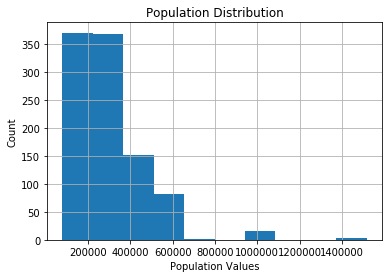

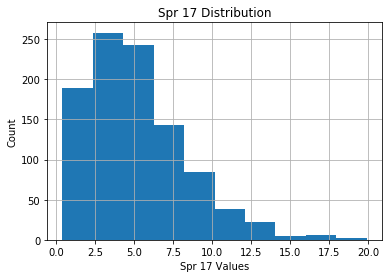

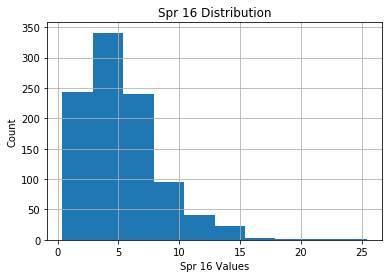

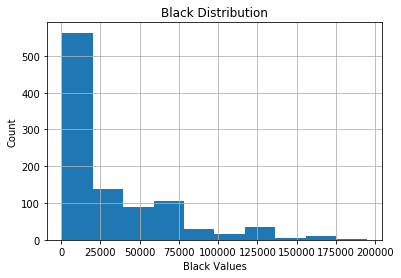

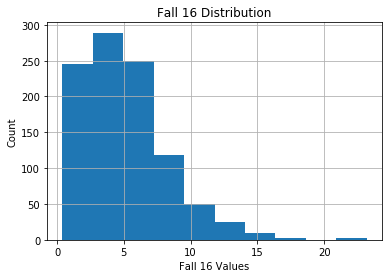

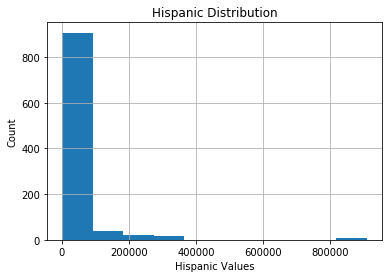

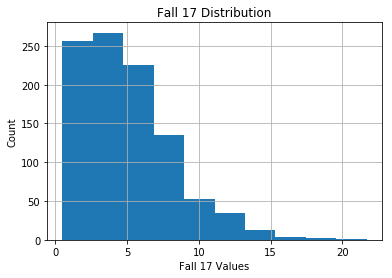

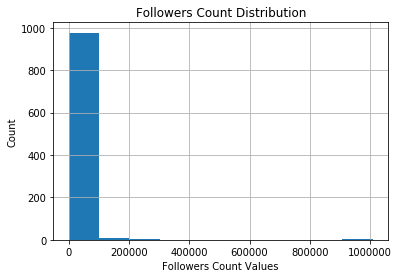

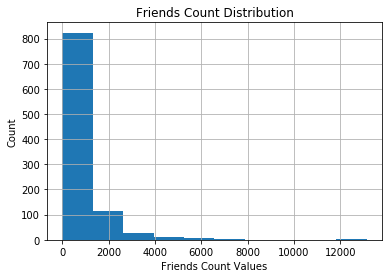

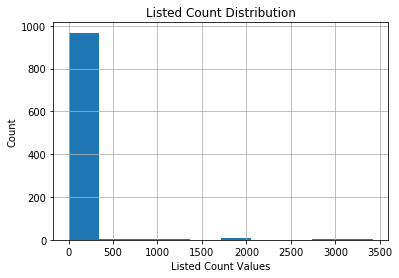

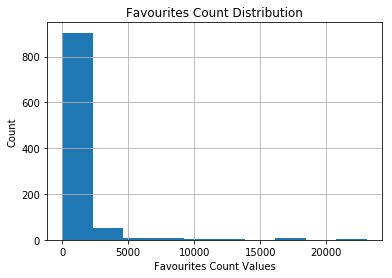

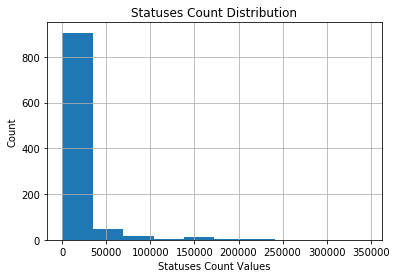

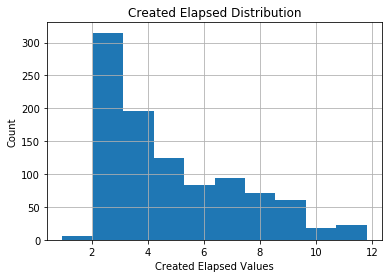

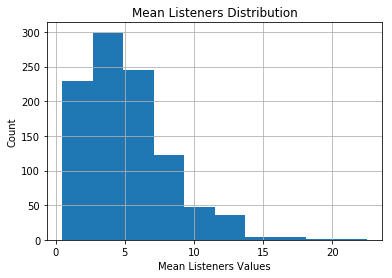

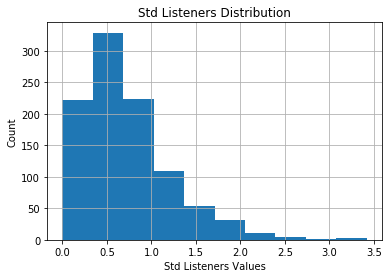

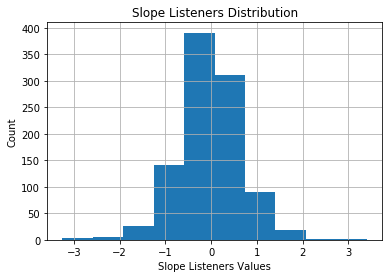

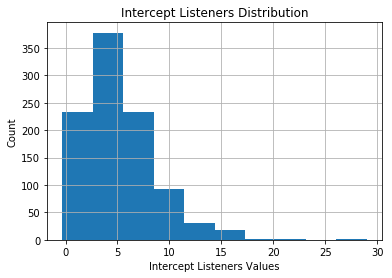

In [9]:
for col in df_feat.dtypes[df_feat.dtypes == 'float64'].index:
    df_feat[col].hist()
    plt.title(col + " Distribution")
    plt.xlabel(col + " Values")
    plt.ylabel("Count")
    plt.savefig(col + "_dist.png")
    plt.show()

In [10]:
# sqrt Population, Spr 17, Spr 16, Fall 16, Fall 17, Created Elapsed
sqrt_cols = ['Fall 17', 'Mean Listeners', 'Std Listeners', 'Intercept Listeners'] #,'Spr 17', 'Spr 16', 'Fall 16']
for col in sqrt_cols:
    df_feat['Sqrt ' + col] = df_feat[col].apply(np.sqrt)
    df_feat.drop(col, axis = 1, inplace = True)

In [11]:
# log Black, Hispanic, Followers Count, Friends Count, Listed Count, Favourites Count, Statuses Count
log_cols = ['Black', 'Hispanic', 'Population', 'Created Elapsed','Followers Count', 'Friends Count', 'Listed Count', 'Favourites Count', 'Statuses Count']
for col in log_cols:
    df_feat['Log ' + col] = np.log(df_feat[col] + 1)
    df_feat.drop(col, axis = 1, inplace = True)

In [12]:
# drop seasonal listeners
df_feat.drop(['Spr 17', 'Spr 16', 'Fall 16'], axis = 1, inplace = True)

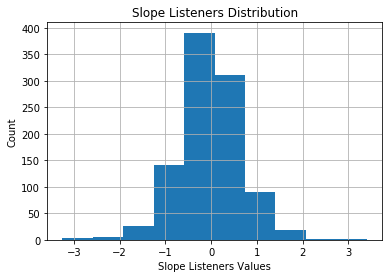

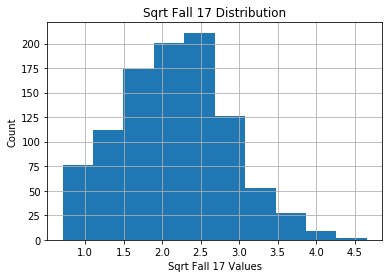

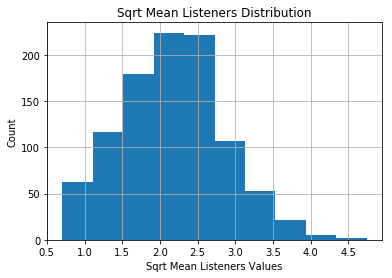

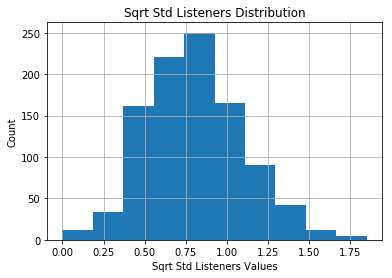

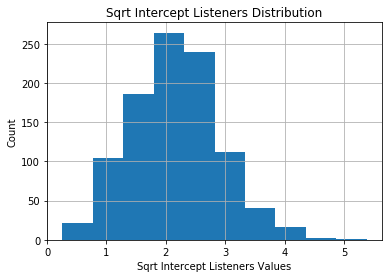

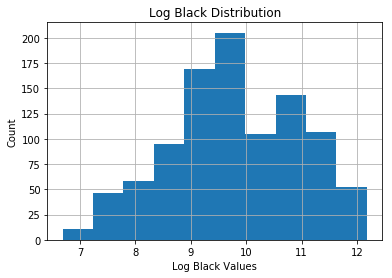

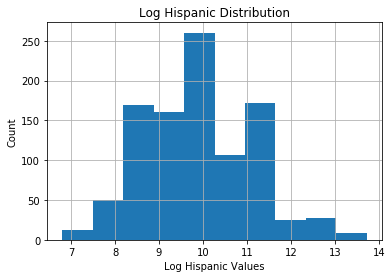

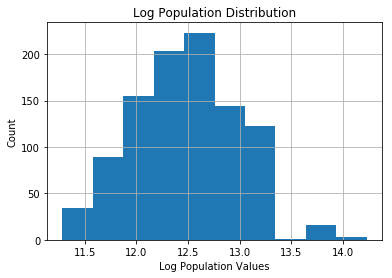

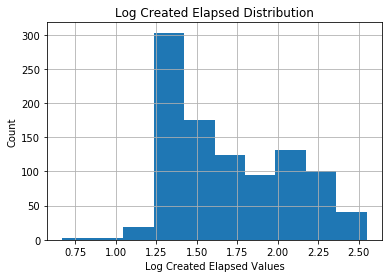

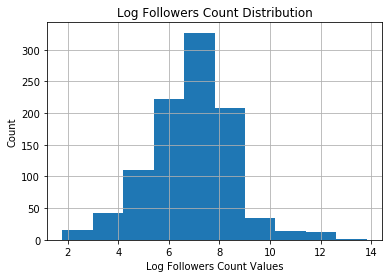

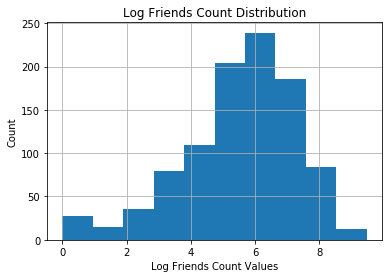

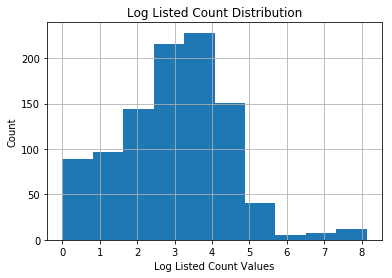

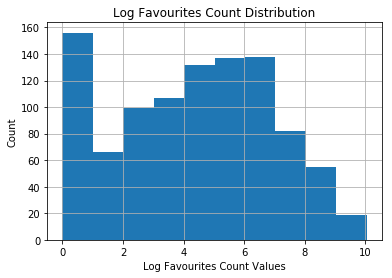

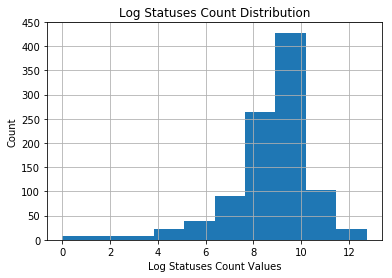

In [13]:
for col in df_feat.dtypes[df_feat.dtypes == 'float64'].index:
    df_feat[col].hist()
    plt.title(col + " Distribution")
    plt.xlabel(col + " Values")
    plt.ylabel("Count")
    plt.savefig(col + "_dist.png")
    plt.show()

In [14]:
df_feat.describe()

,Slope Listeners,Sqrt Fall 17,Sqrt Mean Listeners,Sqrt Std Listeners,Sqrt Intercept Listeners,Log Black,Log Hispanic,Log Population,Log Created Elapsed,Log Followers Count,Log Friends Count,Log Listed Count,Log Favourites Count,Log Statuses Count
count,991.000000,991.000000,991.000000,991.000000,987.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000
mean,-0.029263,2.142538,2.162979,0.800635,2.155395,9.796389,9.889173,12.490369,1.708007,6.883466,5.527381,3.000132,4.294553,8.757461
std,0.686023,0.703273,0.674819,0.294793,0.753806,1.169117,1.205356,0.516932,0.366175,1.667726,1.788519,1.483523,2.620025,1.762918
min,-3.250000,0.707107,0.707107,0.000000,0.258199,6.685861,6.803505,11.284782,0.671622,1.791759,0.000000,0.000000,0.000000,0.000000
25%,-0.400000,1.612452,1.698031,0.600462,1.658305,9.059634,9.024131,12.100162,1.370242,5.857933,4.595120,2.079442,2.302585,8.212430
50%,0.000000,2.144761,2.136976,0.790253,2.160247,9.746892,9.814711,12.473046,1.608820,6.962243,5.796058,3.091042,4.499810,9.096948
75%,0.350000,2.607681,2.604481,0.981139,2.626785,10.803669,10.849357,12.826921,2.037504,7.912785,6.803505,3.988984,6.317165,9.775881
max,3.400000,4.658326,4.743416,1.849862,5.385165,12.178193,13.721421,14.232444,2.550655,13.824437,9.483721,8.138273,10.046592,12.752615


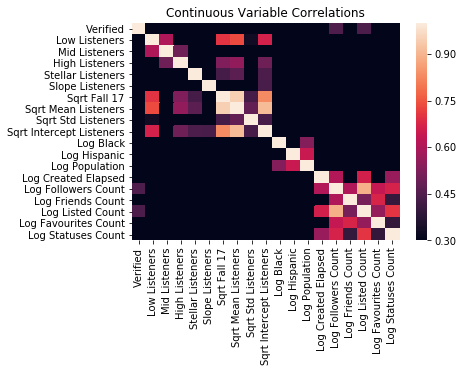

In [15]:
# independent variables
sns.heatmap(abs(df_feat.corr()),vmin = 0.3)
plt.title("Continuous Variable Correlations")
plt.savefig("FeatureCorrelationMatrix.png", bbox_inches="tight")

In [16]:
# combine highly correlated groups of vars 
#Sqrt Spr 17, Sqrt Spr 16, Sqrt Fall 16

#Log Black, Log Hispanic, Log Population 

#Log Listed Count, Log Followers Count, Sqrt Created Elapsed, Log Friends Count, Log Favourites Count, Log Statuses Count


In [17]:
# OHE categorical variables: Format, top 20 Owners, State
# get_dummies Format, State
df_feat = pd.get_dummies(df_feat, columns = ['Format','State'])
# top 20 Owners
top_owners = list(df_feat['Owner'].value_counts()[:20].index)
for owner in top_owners:
    df_feat["Owner_" + owner] = (df_feat['Owner'] == owner).astype(int)
df_feat.drop('Owner',axis = 1, inplace = True)

In [18]:
# conditional group variables: from crosstab, groupby


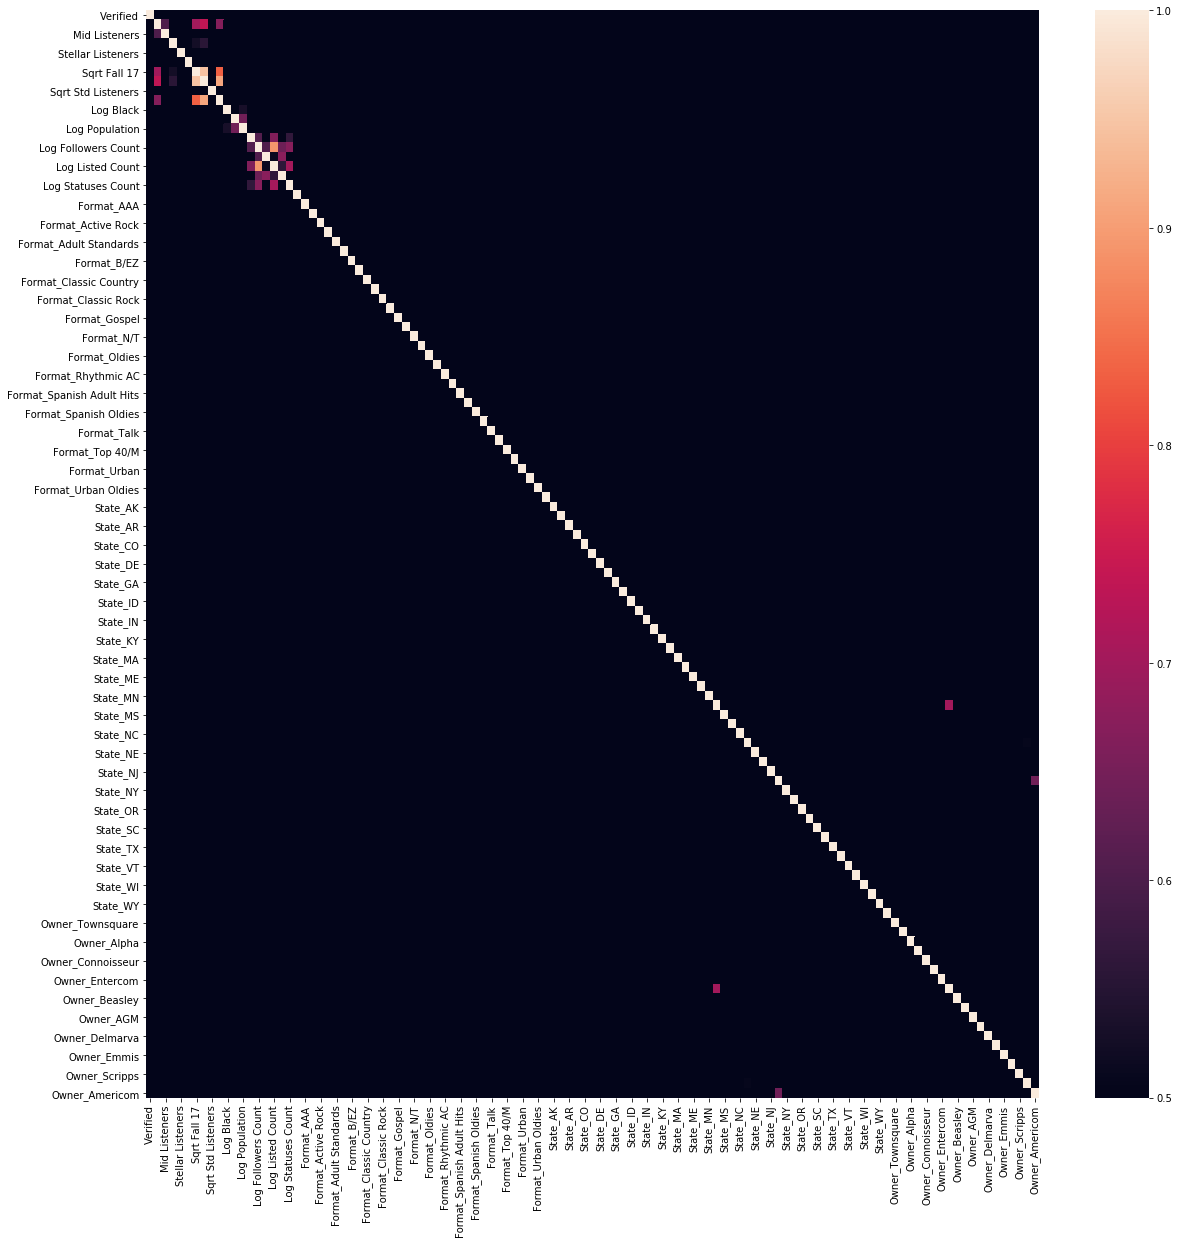

In [19]:
# correlation matrix of all variables
plt.figure(figsize = (20,20))
sns.heatmap(abs(df_feat.corr()), vmin = .5)
plt.show()

In [20]:
# fill nulls with median values
df_feat.fillna(df_feat.median(), inplace = True)
# train_test_split
X = df_feat.drop('Sqrt Fall 17', axis = 1)
Y = df_feat['Sqrt Fall 17']
# normalize X
X_norm = (X - X.min()) / (X.max() - X.min())

In [21]:
df_feat.describe()

,Slope Listeners,Sqrt Fall 17,Sqrt Mean Listeners,Sqrt Std Listeners,Sqrt Intercept Listeners,Log Black,Log Hispanic,Log Population,Log Created Elapsed,Log Followers Count,...,Owner_Hall,Owner_AGM,Owner_Dick,Owner_Delmarva,Owner_Woof Boom,Owner_Emmis,Owner_Neuhoff Media,Owner_Scripps,Owner_Radio FM Media,Owner_Americom
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,...,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000
mean,-0.029263,2.142538,2.162979,0.800635,2.155414,9.796389,9.889173,12.490369,1.708007,6.883466,...,0.009082,0.008073,0.007064,0.007064,0.007064,0.006054,0.006054,0.006054,0.006054,0.005045
std,0.686023,0.703273,0.674819,0.294793,0.752281,1.169117,1.205356,0.516932,0.366175,1.667726,...,0.094912,0.089530,0.083790,0.083790,0.083790,0.077614,0.077614,0.077614,0.077614,0.070887
min,-3.250000,0.707107,0.707107,0.000000,0.258199,6.685861,6.803505,11.284782,0.671622,1.791759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.400000,1.612452,1.698031,0.600462,1.663330,9.059634,9.024131,12.100162,1.370242,5.857933,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.144761,2.136976,0.790253,2.160247,9.746892,9.814711,12.473046,1.608820,6.962243,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.350000,2.607681,2.604481,0.981139,2.626785,10.803669,10.849357,12.826921,2.037504,7.912785,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.400000,4.658326,4.743416,1.849862,5.385165,12.178193,13.721421,14.232444,2.550655,13.824437,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [1.04217827e-01 7.64161806e-02 5.95754019e-02 5.16616923e-02
 4.36539074e-02 4.28456866e-02 3.06988256e-02 2.79512350e-02
 2.69278337e-02 2.25109626e-02 2.10197395e-02 1.88082267e-02
 1.80365854e-02 1.76414524e-02 1.67730159e-02 1.56328184e-02
 1.53511721e-02 1.42227875e-02 1.34806843e-02 1.26910286e-02
 1.24979916e-02 1.19977139e-02 1.13520175e-02 1.10892621e-02
 1.02401757e-02 9.97057237e-03 9.66820323e-03 9.18969480e-03
 9.02175959e-03 8.76445082e-03 8.38912539e-03 8.29048369e-03
 8.03251256e-03 7.82085039e-03 7.49280918e-03 7.16827550e-03
 7.04220868e-03 6.65880593e-03 6.64169353e-03 6.30311149e-03
 6.18043194e-03 6.04076755e-03 5.97807879e-03 5.55361968e-03
 5.51101918e-03 5.29368650e-03 5.21862710e-03 5.10118936e-03
 5.03741364e-03 4.76599732e-03 4.54732689e-03 4.41943067e-03
 4.29751255e-03 4.19605493e-03 4.06928763e-03 3.98905163e-03
 3.88755642e-03 3.79455128e-03 3.65787171e-03 3.613

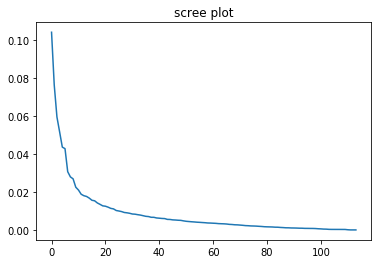

In [22]:
#PCA, n_components = 4 from scree plot
max_components = len(X_norm.columns)
optimal_components = 20
pca = PCA(n_components=max_components)
X_PCA = pca.fit_transform(X_norm)

print('The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_)
print ('Sum of variance explained by {} components\n%0.4f'.format(len(pca.explained_variance_ratio_)) % (pca.explained_variance_ratio_.sum()))
# scree plot
plt.plot(pca.explained_variance_ratio_)
plt.title('scree plot')
plt.show()

In [23]:
# model dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# model building

In [24]:
df_eval = pd.DataFrame()

In [25]:
def evaluate(model, model_name):
    model.fit(X_train,Y_train)
    model_pred = model.predict(X_test)
    evals = np.zeros(3)
    # Mean Absolute Error
    mae_sqrt = metrics.mean_absolute_error(Y_test, model_pred)
    evals[0] = np.mean(abs((Y_test)**2 - (model_pred)**2))
    # R-squared
    evals[1] = metrics.r2_score(Y_test, model_pred)
    # Explained variance
    evals[2] = metrics.explained_variance_score(Y_test, model_pred)
    df_eval[model_name] = evals
    return model_pred

In [26]:
#### Baseline: Mean Listeners
base_pred = X_test['Sqrt Mean Listeners']
# evaluate
evals = [np.mean(abs(Y_test**2 - base_pred**2)), 
         metrics.r2_score(Y_test, base_pred),
         metrics.explained_variance_score(Y_test, base_pred)]
df_eval['Baseline'] = evals

In [27]:
# runtime ~ 0.02 seconds (default train_test_split)
#### Linear Regressor
linear_columns = ['Verified', 'Sqrt Mean Listeners','Sqrt Std Listeners','Slope Listeners','Sqrt Intercept Listeners', 'Log Created Elapsed', 'Log Black','Log Hispanic', 'Log Population', 'Log Listed Count','Log Friends Count','Log Followers Count','Log Favourites Count', 'Log Statuses Count', 'Stellar Listeners','High Listeners','Mid Listeners','Low Listeners'] #,'Sqrt Spr 17','Sqrt Spr 16','Sqrt Fall 16']
start = time.time()
linear = LinearRegression(fit_intercept=True, normalize=False, n_jobs=1)
linear.fit(X_train[linear_columns],Y_train)
linear_pred = linear.predict(X_test[linear_columns])
evals = [np.mean(abs(Y_test**2 - linear_pred**2)), 
         metrics.r2_score(Y_test, linear_pred),
         metrics.explained_variance_score(Y_test, linear_pred)]
df_eval['Linear Regression'] = evals
print ("Runtime %0.2f" % (time.time() - start))

Runtime 0.01


In [28]:
# runtime ~ 1.64 seconds (default train_test_split)
#### RandomForestRegressor
start = time.time()
RFR = RandomForestRegressor(n_estimators=500, max_depth=4, min_samples_split=2, max_features='auto', max_leaf_nodes=None, n_jobs=1)
RFR_pred = evaluate(RFR,'Random Forest')
print ("Runtime %0.2f" % (time.time() - start))

Runtime 1.52


In [29]:
# runtime ~ 3.45 seconds (default train_test_split)
# n_estimators = 1000, max_depth = 4, subsample, 0.5, learning_rate = 0.001
#### Gradient Boost Regressor
start = time.time()
GBR = GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=1.0, max_depth=2, max_features=None, max_leaf_nodes=None)
GBR_pred = evaluate(GBR,'Gradient Boost')
print ("Runtime %0.2f" % (time.time() - start))

Runtime 0.67


In [30]:
df_eval.rename(index={0: 'MAE Score', 
                      1: 'R-squared', 
                      2: 'Explained Variance'
                     }, inplace = True)

In [31]:
# Accuracy scores
display(df_eval)

,Baseline,Linear Regression,Random Forest,Gradient Boost
MAE Score,0.782661,0.743576,0.765904,0.749285
R-squared,0.889993,0.898139,0.891865,0.895336
Explained Variance,0.891066,0.898139,0.891865,0.895336


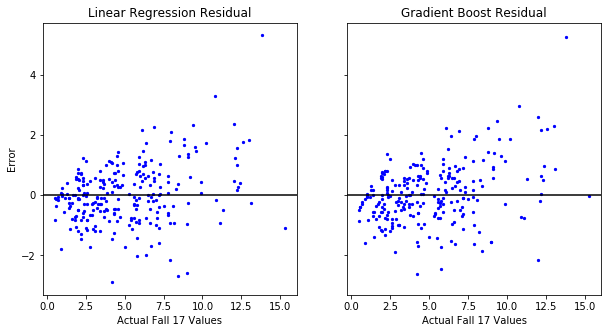

In [32]:
# residuals of highest scoring models
fig, [ax1,ax2] = plt.subplots(1,2, figsize = (10,5), sharey = True)
# Linear Regression
ax1.scatter(Y_test**2,(Y_test**2 - linear_pred**2), color = 'b', s = 5)
ax1.axhline(0, color = 'k')
lr_title = 'Linear Regression Residual'
ax1.set_title(lr_title)
ax1.set_ylabel('Error')
ax1.set_xlabel('Actual Fall 17 Values')
# Gradient Boost
ax2.scatter(Y_test**2,(Y_test**2 - GBR_pred**2), color = 'b', s = 5)
ax2.axhline(0, color = 'k')
gb_title = 'Gradient Boost Residual'
ax2.set_title(gb_title)
ax2.set_xlabel('Actual Fall 17 Values')
plt.savefig("residuals.png")
plt.show()

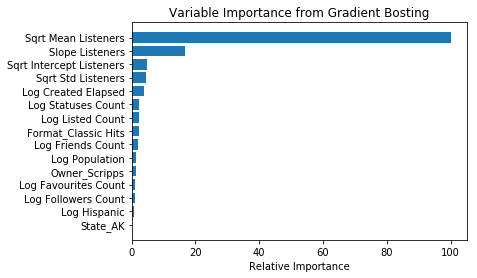

In [33]:
# variable importance: Gradient Boost
# print out the top features from Gradient Boosting
feature_importance = GBR.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-15:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
gb_var_title = 'Variable Importance from Gradient Bosting'
plt.title(gb_var_title)
plt.savefig(gb_var_title + ".png", bbox_inches="tight")
plt.show()

In [34]:
# Random Forest Tree?


# Write-up